# Classification d'images avec l'utilisation de la Focal Loss

implementation de la fonction **Focal Loss** pour améliorer la **classification d'images** dans le cas d'un dataset présentant un **déséquilibre de classe**. 

C'est un exemple assez simple d'utilisation de la Focal Loss qui permet de rendre compte de son comportement (notamment pour la classification background/foreground de l'algorithme RetinaNet de détection d'objets)

In [1]:
# import

import sys
import os

import torch
from torch import nn, optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from model import cnn_model
from loss import FocalLoss
from train import train_one_epoch
from utils import NpArrayDataset
from utils import reduce_datasets
from eval import predict_one_epoch

In [ ]:
# auto-reaload pour les fonctions Python (pour exécution locallocal)

%load_ext autoreload
%autoreload 2

In [ ]:
# téléchargement des datasests de Train / Test au format Numpy

X_train = np.loadtxt("data/input.csv", delimiter=',')
Y_train = np.loadtxt("data/labels.csv", delimiter=',')

X_test = np.loadtxt("data/input_test.csv", delimiter=',')
Y_test = np.loadtxt("data/labels_test.csv", delimiter=',')

print("X_train shape : ", X_train.data.shape)
print("Y_train shape : ", Y_train.data.shape)
print("X_test shape : ", X_test.data.shape)
print("Y_test shape : ", Y_test.data.shape)

X_train shape :  (2000, 30000)
Y_train shape :  (2000,)
X_test shape :  (400, 30000)
Y_test shape :  (400,)


In [4]:
# reformatage des tableaux Numpy au format classique : (Nbre d'échantillons, Hauteur, Largeur, Canaux RGB)

X_train = X_train.reshape(len(X_train), 100, 100, 3)
Y_train = Y_train.reshape(len(Y_train), 1)

X_test = X_test.reshape(len(X_test), 100, 100, 3)
Y_test = Y_test.reshape(len(Y_test), 1)

print("X_train shape : ", X_train.data.shape)
print("Y_train shape : ", Y_train.data.shape)
print("X_test shape : ", X_test.data.shape)
print("Y_test shape : ", Y_test.data.shape)

X_train shape :  (2000, 100, 100, 3)
Y_train shape :  (2000, 1)
X_test shape :  (400, 100, 100, 3)
Y_test shape :  (400, 1)


On dispose ici d'images de taille 100x100 contanat des photos de Chien et Chat.

On remarque que l'on dispose ici de seulement 2000 images pour le set d'entraînement. Il serait donc utile de faire de la **data augmentation** par exemple pour améliorer notre jeu de donnée (cela ne sera pas fait ici)

In [5]:
#  normalisation du jeu de données

X_train = X_train / 255.0
X_test = X_test / 255.0

On va avec la cellule ci-dessous afficher une image tirée au hasard de notre dataset d'entraînement.
Remarque : Vous pouvez relancer la cellule pour voir une autre image s'afficher

affichage de l'image n°1847 : label 1 - type chat


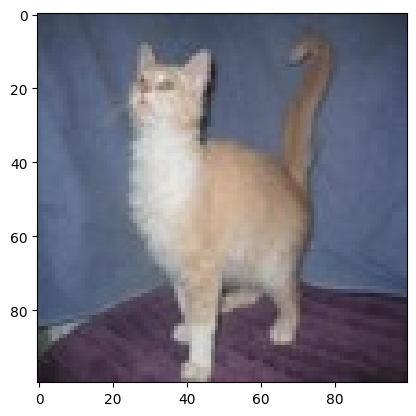

In [9]:
import random

classes = {
    0: 'chien',
    1: 'chat',
}

idx = random.randint(0, len(X_train))
plt.imshow(X_train[idx,:])
print(f"""affichage de l'image n°{idx} : label {int(Y_train[idx][0])} - type {classes[int(Y_train[idx][0])]}""")

/tmp/ipykernel_289551/3806826399.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=noms_labels, palette=['#3498db', '#e67e22'])


Text(0, 0.5, 'nbres images')

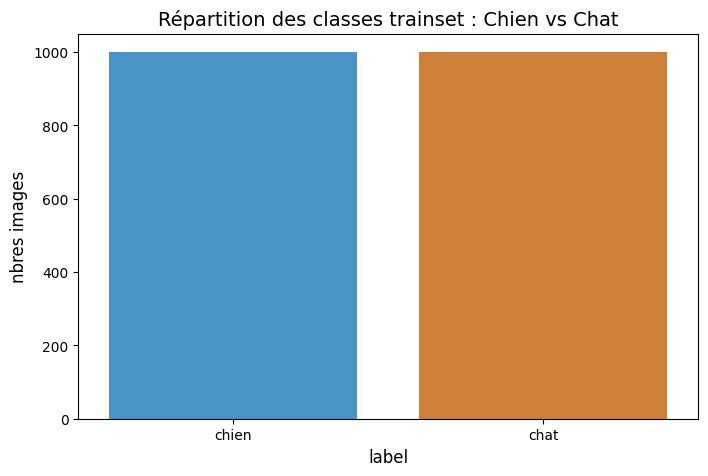

In [87]:
# affichage de la répartition des classes dans notre dataset (équilibré pour le moment...)

noms_labels = [classes[l] for l in Y_train.flatten()]

plt.figure(figsize=(8, 5))

ax = sns.countplot(x=noms_labels, palette=['#3498db', '#e67e22'])

plt.title('Répartition des classes trainset : Chien vs Chat', fontsize=14)
plt.xlabel('label', fontsize=12)
plt.ylabel('nbres images', fontsize=12)

On note qu'il y a ici équipartition des Chiens et Chats dans notre dataset d'entraînement (et test aussi) : on dispose de 1000 images de chien et 1000 images de chat.

In [11]:
# définition des transformations à appliquer à notre jeu de données

image_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

target_transforms = None

## Entraînement de notre CNN sur un dataset équilibré

In [ ]:
# on load les images dans des DataLoader Pytorch

train_set = NpArrayDataset(
    images=X_train,
    labels=Y_train,
    image_transforms=image_transforms,
    label_transforms=target_transforms,
)

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)

test_set = NpArrayDataset(
    images=X_test,
    labels=Y_test,
    image_transforms=image_transforms,
    label_transforms=target_transforms,
)

test_loader = DataLoader(train_set, batch_size=16, shuffle=True)

In [ ]:
# Init the training
model = cnn_model()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

print(DEVICE)
model = model.to(DEVICE)

train_losses = []
valid_losses = []

EPOCHS = 10
# loop over the dataset multiple times
for epoch in range(EPOCHS):
    model.train()
    train_epoch_loss = train_one_epoch(model, criterion, optimizer, train_loader, DEVICE)

    print(f"EPOCH={epoch}, TRAIN={train_epoch_loss:.05f}")

    train_losses.append(train_epoch_loss)

cpu


100%|██████████| 125/125 [00:04<00:00, 25.73it/s]


EPOCH=0, TRAIN=0.68995


100%|██████████| 125/125 [00:04<00:00, 26.86it/s]


EPOCH=1, TRAIN=0.65462


100%|██████████| 125/125 [00:04<00:00, 26.53it/s]


EPOCH=2, TRAIN=0.61771


100%|██████████| 125/125 [00:04<00:00, 26.91it/s]


EPOCH=3, TRAIN=0.58348


100%|██████████| 125/125 [00:04<00:00, 26.30it/s]


EPOCH=4, TRAIN=0.50251


100%|██████████| 125/125 [00:04<00:00, 26.62it/s]


EPOCH=5, TRAIN=0.43448


100%|██████████| 125/125 [00:04<00:00, 27.01it/s]


EPOCH=6, TRAIN=0.34426


100%|██████████| 125/125 [00:04<00:00, 26.86it/s]


EPOCH=7, TRAIN=0.25814


100%|██████████| 125/125 [00:04<00:00, 26.58it/s]


EPOCH=8, TRAIN=0.18475


100%|██████████| 125/125 [00:04<00:00, 26.67it/s]

EPOCH=9, TRAIN=0.13415


In [ ]:
# inférence sur le dataset test

y_true, y_pred = predict_one_epoch(model, test_loader, DEVICE)

100%|██████████| 125/125 [00:01<00:00, 73.43it/s]


Accuracy : 0.9750
F1-Score : 0.9752
Confusion matrix


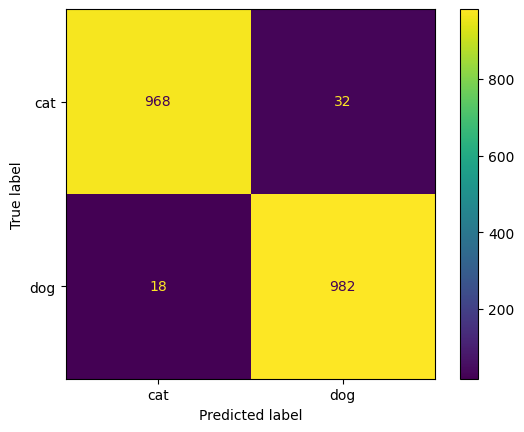

In [ ]:
# affichage des métriques

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy : {acc:.4f}")
print(f"F1-Score : {f1:.4f}")

print("Confusion matrix")
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["chien", "chat"])

disp.plot()
plt.show()


On note une très bonne précision de notre simple modèle CNN : accuracy de 0.97.
Ici, le F1-score est très élevé et identique à l'accuracy, ce qui est attendu avec un jeu de données parfaitement équilibré.
De plus, la matrice de confusion a une belle forme (elle est plutôt symétrique avec beaucoup d'images sur la diagonale)

## Entraînement de notre CNN sur un dataset déséquilibré

On va modifier la structure de notre dataset en y retirant une grande partie d'images de Chat. Ainsi, on va avoir bien plus d'images de **classe 0 (Chien)** que d'images de **classe 1 (Chat)** et donc on va entraîner notre CNN sur un dataset très déséquilibré.

In [17]:
# on utilise la fonction reduce_datasets de utils.py pour retirer une partie des images de Chat de notre dataset

ratio = 0.1 # pilote le ratio de Chat que l'on veut garder dans notre dataset
X_train_unbalanced, Y_train_unbalanced = reduce_datasets(X_train, Y_train, ratio=ratio)
X_test_unbalanced, Y_test_unbalanced = reduce_datasets(X_test, Y_test, ratio=ratio)

/tmp/ipykernel_289551/2332726669.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=noms_labels, palette=['#3498db', '#e67e22'])


Text(0, 0.5, 'nbres images')

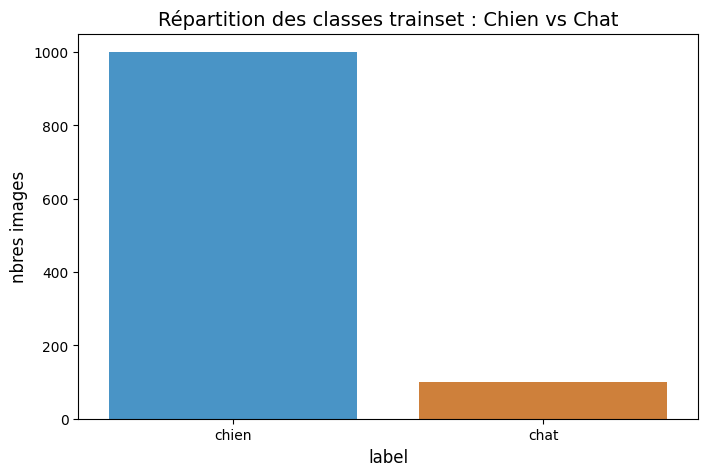

In [18]:
noms_labels = [classes[l] for l in Y_train_unbalanced.flatten()]

plt.figure(figsize=(8, 5))

ax = sns.countplot(x=noms_labels, palette=['#3498db', '#e67e22'])

plt.title('Répartition des classes trainset : Chien vs Chat', fontsize=14)
plt.xlabel('label', fontsize=12)
plt.ylabel('nbres images', fontsize=12)

On note maintenant un fort déséquilibre dans la répartition des 2 classes de notre dataset. Il y a très peu d'images de Chat comparé aux images de Chien... On va voir comment se comporte notre CNN.

In [19]:
# on load les images dans des DataLoader Pytorch

train_set = NpArrayDataset(
    images=X_train_unbalanced,
    labels=Y_train_unbalanced,
    image_transforms=image_transforms,
    label_transforms=target_transforms,
)

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)

test_set = NpArrayDataset(
    images=X_test_unbalanced,
    labels=Y_test_unbalanced,
    image_transforms=image_transforms,
    label_transforms=target_transforms,
)

test_loader = DataLoader(test_set, batch_size=16, shuffle=True)

### Entraînement avec la fonction BinaryCrossEntropy Loss

In [ ]:
# Init the training
model = cnn_model()
criterion = nn.BCEWithLogitsLoss() # Binary Cross-Entropy Loss
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(DEVICE)
model = model.to(DEVICE)

train_losses = []
valid_losses = []

EPOCHS = 15
# loop over the dataset multiple times
for epoch in range(EPOCHS):
    model.train()
    train_epoch_loss = train_one_epoch(model, criterion, optimizer, train_loader, DEVICE)

    print(f"EPOCH={epoch}, TRAIN={train_epoch_loss:.05f}")

    train_losses.append(train_epoch_loss)

cpu


  0%|          | 0/69 [00:00<?, ?it/s]

100%|██████████| 69/69 [00:02<00:00, 29.85it/s]


EPOCH=0, TRAIN=0.35963


100%|██████████| 69/69 [00:02<00:00, 30.70it/s]


EPOCH=1, TRAIN=0.30976


100%|██████████| 69/69 [00:02<00:00, 30.36it/s]


EPOCH=2, TRAIN=0.29141


100%|██████████| 69/69 [00:02<00:00, 31.03it/s]


EPOCH=3, TRAIN=0.26920


100%|██████████| 69/69 [00:02<00:00, 31.57it/s]


EPOCH=4, TRAIN=0.25527


100%|██████████| 69/69 [00:02<00:00, 31.44it/s]


EPOCH=5, TRAIN=0.23990


100%|██████████| 69/69 [00:02<00:00, 32.09it/s]


EPOCH=6, TRAIN=0.20485


100%|██████████| 69/69 [00:02<00:00, 31.53it/s]


EPOCH=7, TRAIN=0.21204


100%|██████████| 69/69 [00:02<00:00, 30.08it/s]


EPOCH=8, TRAIN=0.10927


100%|██████████| 69/69 [00:02<00:00, 29.45it/s]


EPOCH=9, TRAIN=0.04703


100%|██████████| 69/69 [00:02<00:00, 29.23it/s]


EPOCH=10, TRAIN=0.07665


100%|██████████| 69/69 [00:02<00:00, 29.55it/s]


EPOCH=11, TRAIN=0.04740


100%|██████████| 69/69 [00:02<00:00, 29.05it/s]


EPOCH=12, TRAIN=0.04597


100%|██████████| 69/69 [00:02<00:00, 29.40it/s]


EPOCH=13, TRAIN=0.02146


100%|██████████| 69/69 [00:02<00:00, 29.12it/s]

EPOCH=14, TRAIN=0.01223


In [74]:
# inférence sur le dataset test

y_true, y_pred = predict_one_epoch(model, test_loader, DEVICE)

100%|██████████| 14/14 [00:00<00:00, 66.05it/s]


Accuracy : 0.8955
F1-Score : 0.0000
Confusion matrix


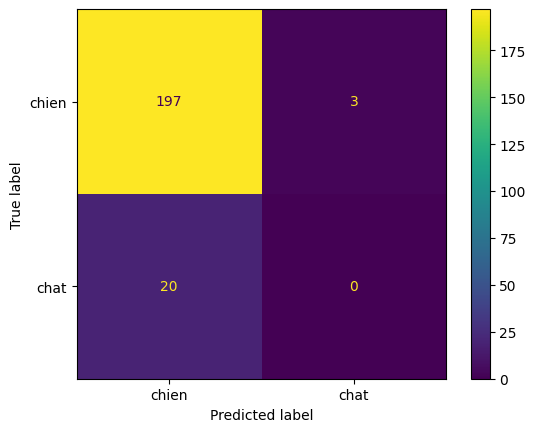

In [75]:
# affichage des métriques

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy : {acc:.4f}")
print(f"F1-Score : {f1:.4f}")

print("Confusion matrix")
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["chien", "chat"])

disp.plot()
plt.show()


On observe ici des résultats bien différents de ce qu'on avait avec un dataset équilibré :

- On a une accuracy légèrement inférieure (0.90 contre 0.97). Ceci était prévisible car en retirant 90% des images de Chats, on a presque divisé la taille de notre dataset d'entraînement par 2. Cependant, la précision globale reste très bonne.

- Par contre, le f1-score a chuté drastiquement (0.00 contre 0.97). En effet, en regardant la matrice de confusion, on remarque que le modèle ne prédit presque jamais la classe 1 (Chat), et dans le cas présent il n'a jamais eu bon...

Lors de l'apprentissage, comme les images de Chien sont largement prédominantes, le modèle a appris à prédire tout le temps la classe 0 (Chien) pour minimiser sa Loss (et maximiser sa précision). C'est le problème lorsque l'on apprend avec un dataset déséquilibré.

### Entraînement avec la fonction Focal Loss

On va maintenant remplacer la fonction **BCELoss** par la fonction **FocalLoss** pour la variable criterion utilisé lors de l'entraînement de notre modèle.

Ici, on a décider de choisir les valeurs **gamma=2** et **alpha=0.85** pour les hyperparamètres, mais vous êtres libre de les changer pour voir leur influence. 

- plus alpha est proche de 1, plus on donne de l'importance à la classe 1 lors de l'entraînement (et inversement)
- plus gamma est grand, plus on va négliger l'influence des images "faciles" à classifier dans le calcul de la loss 

In [ ]:
# Init the training
model = cnn_model()

criterion = FocalLoss(gamma=2, alpha=0.85, task_type='binary') # Focal Loss
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

print(DEVICE)
model = model.to(DEVICE)

train_losses = []
valid_losses = []

EPOCHS = 15
# loop over the dataset multiple times
for epoch in range(EPOCHS):
    model.train()
    train_epoch_loss = train_one_epoch(model, criterion, optimizer, train_loader, DEVICE)

    print(f"EPOCH={epoch+1}, TRAIN={train_epoch_loss:.05f}")

    train_losses.append(train_epoch_loss)

cpu


100%|██████████| 69/69 [00:02<00:00, 28.15it/s]


EPOCH=1, TRAIN=0.03929


100%|██████████| 69/69 [00:02<00:00, 29.39it/s]


EPOCH=2, TRAIN=0.03370


100%|██████████| 69/69 [00:02<00:00, 28.10it/s]


EPOCH=3, TRAIN=0.03229


100%|██████████| 69/69 [00:02<00:00, 29.07it/s]


EPOCH=4, TRAIN=0.03005


100%|██████████| 69/69 [00:02<00:00, 28.43it/s]


EPOCH=5, TRAIN=0.02745


100%|██████████| 69/69 [00:02<00:00, 28.92it/s]


EPOCH=6, TRAIN=0.02519


100%|██████████| 69/69 [00:02<00:00, 29.11it/s]


EPOCH=7, TRAIN=0.01987


100%|██████████| 69/69 [00:02<00:00, 29.34it/s]


EPOCH=8, TRAIN=0.01758


100%|██████████| 69/69 [00:02<00:00, 28.95it/s]


EPOCH=9, TRAIN=0.01259


100%|██████████| 69/69 [00:02<00:00, 28.92it/s]


EPOCH=10, TRAIN=0.00905


100%|██████████| 69/69 [00:02<00:00, 28.04it/s]


EPOCH=11, TRAIN=0.00698


100%|██████████| 69/69 [00:02<00:00, 28.88it/s]


EPOCH=12, TRAIN=0.00544


100%|██████████| 69/69 [00:02<00:00, 28.08it/s]


EPOCH=13, TRAIN=0.00354


100%|██████████| 69/69 [00:02<00:00, 28.85it/s]


EPOCH=14, TRAIN=0.00193


100%|██████████| 69/69 [00:02<00:00, 28.70it/s]

EPOCH=15, TRAIN=0.00160


In [85]:
y_true, y_pred = predict_one_epoch(model, test_loader, DEVICE)

100%|██████████| 14/14 [00:00<00:00, 71.10it/s]


Accuracy : 0.8591
F1-Score : 0.2439
Confusion matrix


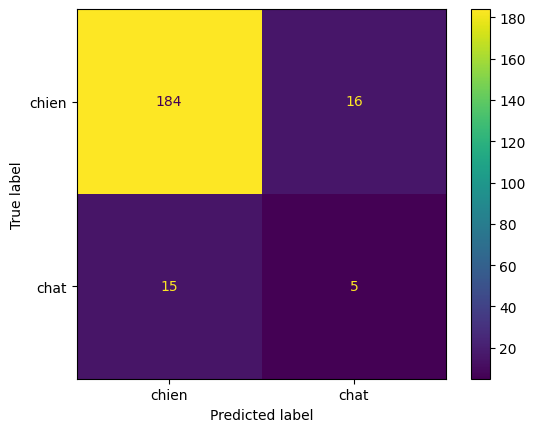

In [86]:
# affichage des métriques

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy : {acc:.4f}")
print(f"F1-Score : {f1:.4f}")

print("Confusion matrix")
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["chien", "chat"])

disp.plot()
plt.show()

On remarque ici avec la matrice de confusion que le modèle est bien plus apte à faire la prédiction "Chat". En effet, il a fait au total 21 prédiction de classe 1 contre 3 avec l'entraînement précédent. Ainsi, le modèle ne se contente plus de prédire uniquement "Chien" pour augmenter son accuracy mais il essaye aussi de prédire "Chat" même si c'est risqué.

Concernant les métriques, on observe une amélioration du f1-score (0.24 contre 0.00) mais on note cependant une légère baisse en terme d'accuracy (0.85 contre 0.89). Le modèle a pris plus de risque en tentant de prédire "Chat" et a perdu en précision : ce dataset test est trop peu fournit en images, et notamment en images de chat, pour que la méthode soit bénéfique en terme de précision.

**ATTENTION** : le dataset utilisé est assez simple (peu d'images et des images simples à classifier avec un modèle basique) et il est donc compliqué d'obtenir des gains significatif avec l'utilisation de la Focal Loss.

On a cependant, à travers cet exemple simple, qui était possible avec l'utilisation de la Focal Loss, de redonner de l'importance à la classe minoritaire dans un dataset déséquilibré !